<a href="https://colab.research.google.com/github/adamgarai98/UCL_MSc_Project/blob/main/Model_Training_Evaluation/Classification/Classification_Dorsal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building, training and evaluating classification model (Dorsal)

Classification model utilising partial transfer learning achieving good results. This file in particular is the dorsal view classification model and achieves and average F1-Score of 0.96 on the test set. Notebook also contains model evaluation.

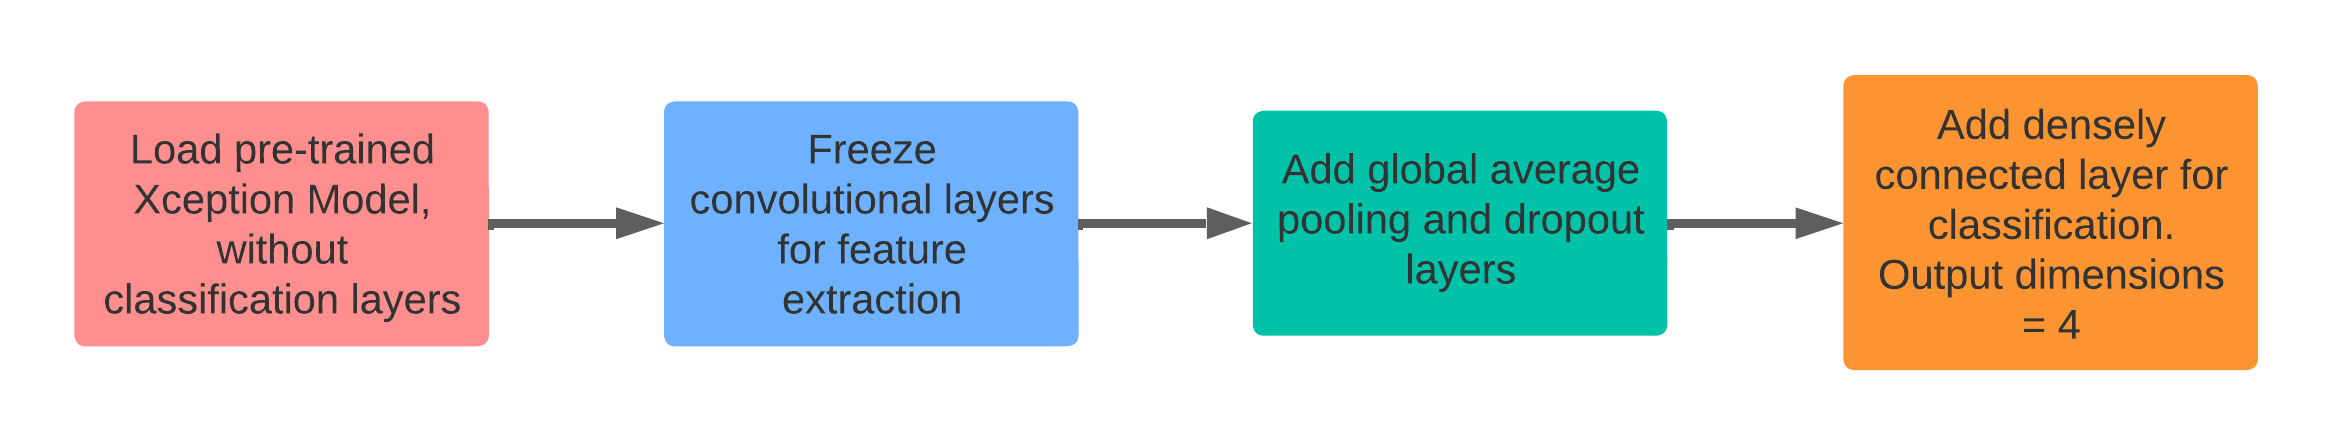
   


#Imports

In [ ]:
# Imports
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils import img_to_array
from keras import applications
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import pickle

Mounted at /content/drive/


#Importing Data

In [ ]:
#Mount drive and get paths
drive.mount('/content/drive/')

# set script location to own development space
MY_DEVELOPMENT_SPACE = '/content/drive/MyDrive/NHM_Project/'
os.chdir(MY_DEVELOPMENT_SPACE)

# dataframe/image paths, change to own path
dataframe_path = MY_DEVELOPMENT_SPACE + "dataframes/"
image_data_path = MY_DEVELOPMENT_SPACE + 'ALICE_data/'

In [ ]:
# batch and image sizes for model training
BATCH_SIZE = 32
IMG_SIZE = (299, 299) #299 for exception

In [ ]:
# Import dataframes (Dorsal)
dataset_train = pd.read_csv(dataframe_path + 'trainDF_dors.csv', index_col=0)
dataset_valid = pd.read_csv(dataframe_path + 'validDF_dors.csv', index_col=0)
dataset_test = pd.read_csv(dataframe_path + 'testDF_dors.csv', index_col=0)

In [ ]:
# At the moment just empty ImageDataGenerators, since rescaling is done with preprocess_input
train_datagen=ImageDataGenerator()
valid_datagen=ImageDataGenerator()
test_datagen=ImageDataGenerator()

In [ ]:
# Make train datagenerator with shuffle = True

# Side note, I was concerned about the class_indicies being different between the train/test/validation, but from the documentation, class indicies are decided alphanumerically,
# so it is consistent between the generators.
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe

train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                      x_col="image_path",
                                                      y_col="target",
                                                      target_size=IMG_SIZE,
                                                      class_mode="categorical",
                                                      batch_size=BATCH_SIZE,
                                                      validate_filenames=True,
                                                      shuffle=True
                                                      )

Found 209 validated image filenames belonging to 4 classes.


In [ ]:
# Make validation datagenerator with shuffle = True

valid_datagenerator=valid_datagen.flow_from_dataframe(dataframe=dataset_valid,
                                                      x_col="image_path",
                                                      y_col="target",
                                                      target_size=IMG_SIZE,
                                                      class_mode="categorical",
                                                      batch_size=BATCH_SIZE,
                                                      validate_filenames=True,
                                                      shuffle=True
                                                      )

Found 70 validated image filenames belonging to 4 classes.


In [ ]:
# Make test datagenerator with shuffle = FALSE, so that accuracy and other metrics can be computed

test_datagenerator=test_datagen.flow_from_dataframe(dataframe=dataset_test,
                                                      x_col="image_path",
                                                      y_col="target",
                                                      target_size=IMG_SIZE,
                                                      class_mode="categorical",
                                                      batch_size=BATCH_SIZE,
                                                      validate_filenames=True,
                                                      shuffle=False
                                                      )

Found 70 validated image filenames belonging to 4 classes.


In [ ]:
#Test order/ indicies values if needed

#train_datagenerator.class_indices
#valid_datagenerator.class_indices
#test_datagenerator.class_indices

{'Ephemera vulgata': 0,
 'Lebia viridis': 1,
 'Leuctra fusca': 2,
 'Limnephilus nigriceps': 3}

#Model Building

In [ ]:
#Can do augmentation here if wanted
#Possible augmentations can be seen in Keras documentation
#If used, remember to include the layer in model building further down
data_augmentation = tf.keras.Sequential([
])

In [ ]:
# Pre processing
preprocess_input = tf.keras.applications.xception.preprocess_input

In [ ]:
# Create the base model from the pre-trained model Xception
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_datagenerator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 2048)


In [ ]:
#Freeze convolutional base
base_model.trainable = False

In [ ]:
# Base model architecture
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
#Define model
inputs = tf.keras.Input(shape=(299, 299, 3))
#x = data_augmentation(inputs)
x = (inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

In [ ]:
#Output layer
#Softmax activation function and output dimensions = 4 since 4 classes
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

In [ ]:
#Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
              )

In [ ]:
#Initial metrics
loss0, accuracy0, precision0, recall0 = model.evaluate(test_datagenerator)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))

#Model Training

In [ ]:
#Train the model
history = model.fit(train_datagenerator,
                    steps_per_epoch = np.math.ceil(train_datagenerator.samples / train_datagenerator.batch_size),
                    batch_size=BATCH_SIZE,
                    epochs=25,
                    validation_data=valid_datagenerator,
                    validation_steps = np.math.ceil(valid_datagenerator.samples / valid_datagenerator.batch_size),
                    validation_batch_size=BATCH_SIZE
                    )

Epoch 1/25
7/7 [==============================] - 86s 12s/step - loss: 1.3448 - categorical_accuracy: 0.3206 - precision: 0.3750 - recall: 0.0144 - val_loss: 1.1596 - val_categorical_accuracy: 0.5143 - val_precision: 0.8333 - val_recall: 0.1429
Epoch 2/25
7/7 [==============================] - 10s 1s/step - loss: 0.9828 - categorical_accuracy: 0.5981 - precision: 0.7701 - recall: 0.3206 - val_loss: 0.8666 - val_categorical_accuracy: 0.6714 - val_precision: 0.8387 - val_recall: 0.3714
Epoch 3/25
7/7 [==============================] - 9s 1s/step - loss: 0.7111 - categorical_accuracy: 0.8325 - precision: 0.9237 - recall: 0.5789 - val_loss: 0.6634 - val_categorical_accuracy: 0.8571 - val_precision: 0.9184 - val_recall: 0.6429
Epoch 4/25
7/7 [==============================] - 10s 1s/step - loss: 0.5587 - categorical_accuracy: 0.8900 - precision: 0.9639 - recall: 0.7656 - val_loss: 0.5534 - val_categorical_accuracy: 0.8857 - val_precision: 0.9310 - val_recall: 0.7714
Epoch 5/25
7/7 [========

#Model Evaluation

##**Note: Training and validation: accuracy/precision/loss code for BOTH view angle models can be seen in this notebook**




In [ ]:
#Save the history files, for further graph plotting etc
#Make sure to use own paths for following section
with open('/content/drive/MyDrive/NHM_Project/Saved_Models/Classification/History/Xception_D', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
#Open history file for this model
with open('/content/drive/MyDrive/NHM_Project/Saved_Models/Classification/History/Xception_D', "rb") as file_pi:
    history = pickle.load(file_pi)

In [ ]:
#Open history file for lateral model
with open('/content/drive/MyDrive/NHM_Project/Saved_Models/Classification/History/Xception_L', "rb") as file_pi:
    history1 = pickle.load(file_pi)

In [ ]:
print(history.keys())

dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall'])


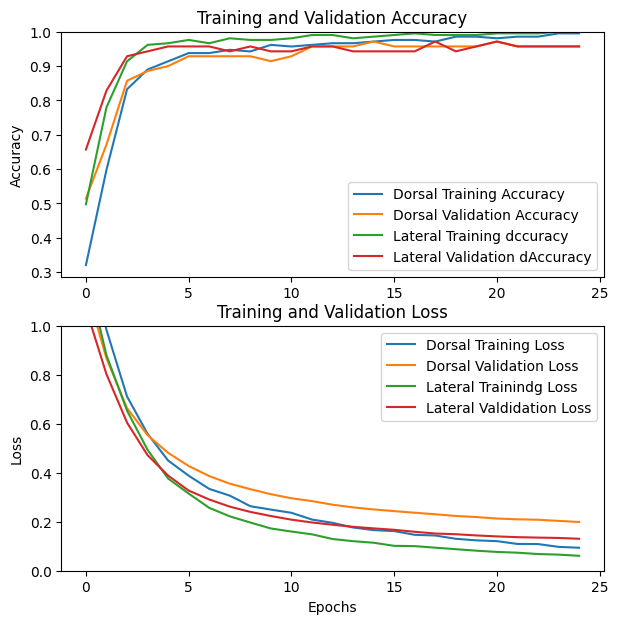

In [ ]:
#Plot graphs

acc = history['categorical_accuracy']
val_acc = history['val_categorical_accuracy']

acc1 = history1['categorical_accuracy']
val_acc1 = history1['val_categorical_accuracy']

loss = history['loss']
val_loss = history['val_loss']

loss1 = history1['loss']
val_loss1 = history1['val_loss']

plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Dorsal Training Accuracy')
plt.plot(val_acc, label='Dorsal Validation Accuracy')
plt.plot(acc1, label='Lateral Training dccuracy')
plt.plot(val_acc1, label='Lateral Validation dAccuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Dorsal Training Loss')
plt.plot(val_loss, label='Dorsal Validation Loss')
plt.plot(loss1, label='Lateral Trainindg Loss')
plt.plot(val_loss1, label='Lateral Valdidation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')


plt.show()

In [ ]:
test_datagenerator.reset()

loss1, accuracy1, precision1, recall1 = model.evaluate(test_datagenerator)

3/3 [==============================] - 17s 8s/step - loss: 0.1607 - categorical_accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571


In [ ]:
print(" loss: {:.2f}".format(loss1))
print(" accuracy: {:.2f}".format(accuracy1))
print(" precision: {:.2f}".format(precision1))
print(" recall: {:.2f}".format(recall1))

 loss: 0.16
 accuracy: 0.96
 precision: 0.96
 recall: 0.96


In [ ]:
#Classification report and confusion matrix
test_datagenerator.reset()

test_steps_per_epoch = np.math.ceil(test_datagenerator.samples / test_datagenerator.batch_size)

predictions = model.predict_generator(test_datagenerator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_datagenerator.classes
class_labels = list(test_datagenerator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_labels)

<ipython-input-25-86e58d3eb5b9>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_datagenerator, steps=test_steps_per_epoch)


                       precision    recall  f1-score   support

     Ephemera vulgata       0.94      1.00      0.97        16
        Lebia viridis       1.00      1.00      1.00        10
        Leuctra fusca       0.91      1.00      0.95        21
Limnephilus nigriceps       1.00      0.87      0.93        23

             accuracy                           0.96        70
            macro avg       0.96      0.97      0.96        70
         weighted avg       0.96      0.96      0.96        70

[[16  0  0  0]
 [ 0 10  0  0]
 [ 0  0 21  0]
 [ 1  0  2 20]]


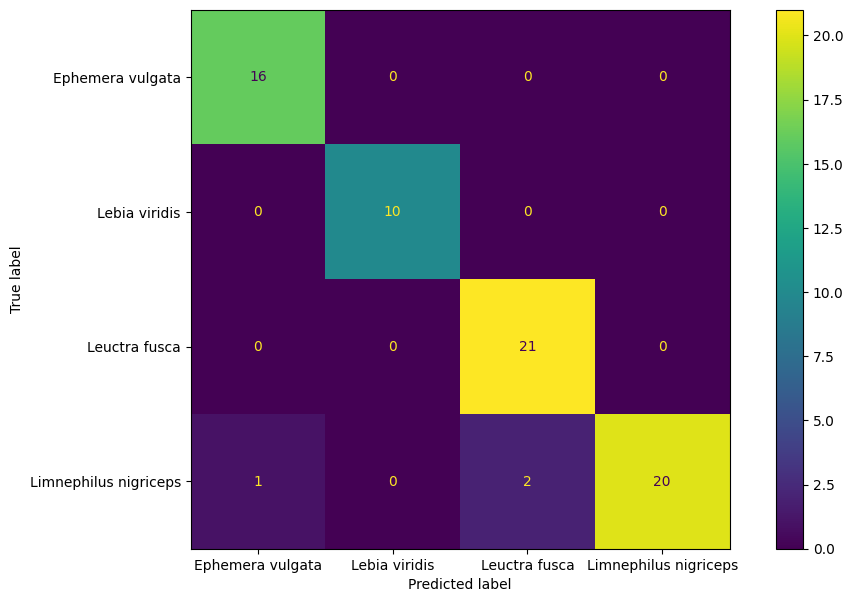

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
disp.plot(ax=ax)

In [ ]:
test_datagenerator.reset()

test_steps_per_epoch = np.math.ceil(test_datagenerator.samples / test_datagenerator.batch_size)

predictions = model.predict_generator(test_datagenerator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_datagenerator.classes
class_labels = list(test_datagenerator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

cm=confusion_matrix(true_classes,predicted_classes,normalize="all")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_labels)

<ipython-input-14-de50f6c9ee22>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_datagenerator, steps=test_steps_per_epoch)


                       precision    recall  f1-score   support

     Ephemera vulgata       0.94      1.00      0.97        16
        Lebia viridis       1.00      1.00      1.00        10
        Leuctra fusca       0.91      1.00      0.95        21
Limnephilus nigriceps       1.00      0.87      0.93        23

             accuracy                           0.96        70
            macro avg       0.96      0.97      0.96        70
         weighted avg       0.96      0.96      0.96        70

[[0.22857143 0.         0.         0.        ]
 [0.         0.14285714 0.         0.        ]
 [0.         0.         0.3        0.        ]
 [0.01428571 0.         0.02857143 0.28571429]]


In [ ]:
cm=confusion_matrix(true_classes,predicted_classes,normalize="true")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_labels)

[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.04347826 0.         0.08695652 0.86956522]]


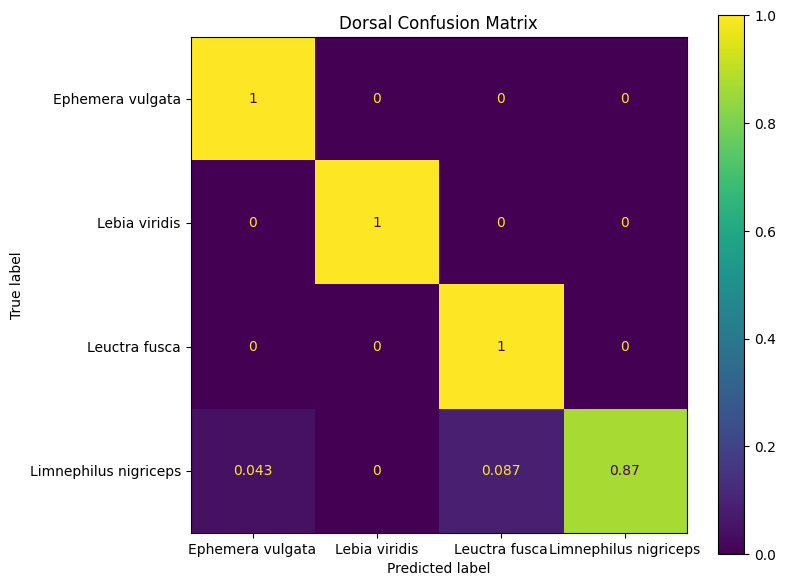

In [ ]:
#Normalised Confusion Matrix
fig, ax = plt.subplots(figsize=(8,7))
plt.title("Dorsal Confusion Matrix")
disp.plot(ax=ax)

#Model Saving

In [ ]:
#Saving
#Save to own path
model.save('/content/drive/MyDrive/NHM_Project/Saved_Models/Classification/Xception_D')


In [ ]:
#Demonstrating model loading
#Load from own path
model = tf.keras.models.load_model('/content/drive/MyDrive/NHM_Project/Saved_Models/Classification/Xception_D')

In [ ]:
#Test using loaded model

test_datagenerator.reset()

test_steps_per_epoch = np.math.ceil(test_datagenerator.samples / test_datagenerator.batch_size)

predictions = LoadedModel.predict_generator(test_datagenerator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_datagenerator.classes
class_labels = list(test_datagenerator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
#Cool

<ipython-input-29-4c35c8451506>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = LoadedModel.predict_generator(test_datagenerator, steps=test_steps_per_epoch)


                       precision    recall  f1-score   support

     Ephemera vulgata       1.00      1.00      1.00        16
        Lebia viridis       0.91      1.00      0.95        10
        Leuctra fusca       0.91      0.95      0.93        21
Limnephilus nigriceps       1.00      0.91      0.95        23

             accuracy                           0.96        70
            macro avg       0.95      0.97      0.96        70
         weighted avg       0.96      0.96      0.96        70

